In [1]:
import os

import h5py
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from tqdm.auto import tqdm
from PIL import Image

from models import VBPR, ACF, CuratorNet
from utils.data import extract_embedding
from utils.metrics import (
    auc_exact,
    nDCG,
    precision,
    recall,
    reciprocal_rank,
)

# Evaluation procedure

In [2]:
DATASET = "Wikimedia"

# Model
MODEL = "ACF"
assert MODEL in ["CuratorNet", "VBPR", "ACF"]

FEATURE_EXTRACTOR = "resnet50"
assert FEATURE_EXTRACTOR in ["alexnet", "vgg16", "resnet50"]

FEATURE_LAYER = "layer4"
FEATURE_LAYER = FEATURE_LAYER if MODEL == "ACF" else ""

In [3]:
# Mode
# Use 'MODE_PROFILE = True' for CuratorNet-like training
# Use 'MODE_PROFILE = False' for VBPR-like training
MODE_PROFILE = MODEL in ["CuratorNet"]
MODE_PROFILE = "profile" if MODE_PROFILE else "user"

# Checkpoint (ex. 'VBPR_wikimedia')
CHECKPOINT = f"{MODEL}_wikimedia"

In [4]:
# Paths (general)
CHECKPOINT_EXT = "pt" if MODEL == "ACF" else "tar" 
CHECKPOINT_PATH = os.path.join("checkpoints", f"{CHECKPOINT}.{CHECKPOINT_EXT}")
FEATURE_EXTRACTOR = f"{FEATURE_EXTRACTOR}-{FEATURE_LAYER}" if FEATURE_LAYER else FEATURE_EXTRACTOR
EMBEDDING_PATH = os.path.join("data", DATASET, f"embedding-{FEATURE_EXTRACTOR}.h5")
EVALUATION_PATH = os.path.join("data", DATASET, f"naive-{MODE_PROFILE}-evaluation.csv")

# Paths (images)
IMAGES_DIR = os.path.join("/", "mnt", "data2", "wikimedia", "mini-images-224-224-v2")

# General constants
RNG_SEED = 0
USE_GPU = True

In [6]:
# Freezing RNG seed if needed
if RNG_SEED is not None:
    print(f"\nUsing random seed... ({RNG_SEED})")
    torch.manual_seed(RNG_SEED)



Using random seed... (0)


In [7]:
# Load embedding from file
print(f"\nLoading embedding from file... ({EMBEDDING_PATH})")
with h5py.File(EMBEDDING_PATH) as embedding_file:
    print(embedding_file.keys())
    filenames = embedding_file['image_filenames'][:].tolist()
    filenames = [fn.decode('utf-8') for fn in filenames]
    print("\nExtracting data into variables...")
    item_index2fn = dict(enumerate(filenames))
    features_database = embedding_file['resnet50/layer4']
    print(f">> Features shape: {features_database.shape}")

# embedding = np.load(EMBEDDING_PATH, allow_pickle=True)

# # Extract features and "id2index" mapping

# features, _, item_index2fn = extract_embedding(embedding, verbose=True)
# 
# del embedding  # Release some memory

# Load evaluation dataframe
print("\nLoad evaluation dataframe")
evaluation_df = pd.read_csv(EVALUATION_PATH)
# Transform lists from str to int
string_to_list = lambda s: list(map(int, s.split()))
evaluation_df["profile"] = evaluation_df["profile"].apply(
    lambda s: string_to_list(s) if isinstance(s, str) else s,
)
evaluation_df["predict"] = evaluation_df["predict"].apply(
    lambda s: string_to_list(s) if isinstance(s, str) else s,
)
# Group evaluations by profile and user
evaluation_df["profile"] = evaluation_df["profile"].map(tuple)
evaluation_df = evaluation_df.groupby(["profile", "user_id"]).agg({"predict": sum}).reset_index()
evaluation_df["profile"] = evaluation_df["profile"].map(list)
print(f">> Evaluation: {evaluation_df.shape}")



Loading embedding from file... (data/Wikimedia/embedding-resnet50-layer4.h5)
<KeysViewHDF5 ['image_filenames', 'resnet50']>

Extracting data into variables...
>> Features shape: (32958, 2048, 7, 7)

Load evaluation dataframe
>> Evaluation: (804, 3)


In [8]:
# Create device instance
print("\nDevice initialization")
device = torch.device("cuda:0" if torch.cuda.is_available() and USE_GPU else "cpu")
if torch.cuda.is_available() != USE_GPU:
    print((f"\nNotice: Not using GPU - "
           f"Cuda available ({torch.cuda.is_available()}) "
           f"does not match USE_GPU ({USE_GPU})"
    ))

# Loading checkpoint
if CHECKPOINT is not None:
    print("\nLoading checkpoint")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device("cpu"))
    if 'epoch' in checkpoint and 'accuracy' in checkpoint:
        print(f">> Best epoch: {checkpoint['epoch']} | Best accuracy: {checkpoint['accuracy']}")
    elif 'epoch' in checkpoint and 'loss' in checkpoint:
        print(f">> Best epoch: {checkpoint['epoch']} | Best Loss: {checkpoint['loss']}")

# Model initialization
print("\nModel initialization")
model = ACF.from_checkpoint(checkpoint, device=device)#, force_h5=True)
    
# Change model mode to eval
print("\nChanging model mode to eval")
model.eval()



Device initialization

Loading checkpoint
>> Best epoch: 3 | Best Loss: 0.16081808226229202

Model initialization

Changing model mode to eval


ACF(
  (item_model): Embedding(32959, 256, padding_idx=0)
  (user_model): ACFUserNet(
    (feats): ACFFeatureNet(
      (dim_reductor): Linear(in_features=2048, out_features=256, bias=True)
      (w_x): Linear(in_features=256, out_features=256, bias=True)
      (w_u): Linear(in_features=256, out_features=256, bias=True)
      (w): Linear(in_features=256, out_features=1, bias=True)
    )
    (user_embedding): Embedding(3830, 256)
    (profile_embedding): Embedding(32959, 256, padding_idx=0)
    (w_u): Linear(in_features=256, out_features=256, bias=True)
    (w_v): Linear(in_features=256, out_features=256, bias=True)
    (w_p): Linear(in_features=256, out_features=256, bias=True)
    (w_x): Linear(in_features=256, out_features=256, bias=True)
    (w): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [9]:
# Predict all
# If True, ranks every item including already consumed items
# If False, ranks ALL - PROFILE (consumed) + PREDICT (ground truth)
PREDICT_ALL = False
N_ITEMS = len(item_index2fn)

## Results inspection

In [10]:
to_std_size = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

In [11]:
ROW = 1

In [12]:
# Row in evaluation dataframe
row = evaluation_df.iloc[ROW]

# Load data into tensors
profile = torch.tensor(row.profile).to(device, non_blocking=True).unsqueeze(0)
user_id = torch.tensor([int(row.user_id)]).to(device, non_blocking=True)
predict = torch.tensor(row.predict).to(device, non_blocking=True)

# Prediction
acf_profile = profile + 1
scores, *attns = model.recommend_all(user_id, acf_profile, return_attentions=True)
component_attns, profile_attns = attns

# Ranking
pos_of_evals = (torch.argsort(scores, descending=True)[..., None] == predict).any(-1).nonzero().flatten()
if not PREDICT_ALL:
    pos_of_profi = (torch.argsort(scores, descending=True)[..., None] == profile).any(-1).nonzero().flatten()
    pos_of_evals -= (pos_of_profi < pos_of_evals).sum()

# Display metrics
print(f"| {'-' * 15} | {'-' * 7} |")
print(f"| {'Metric':^15} | {'Score':^7} |")
print(f"| {'-' * 15} | {'-' * 7} |")
print(f"| {'AUC':^15} | {auc_exact(pos_of_evals, N_ITEMS):.5f} |")
print(f"| {'RR':^15} | {reciprocal_rank(pos_of_evals):.5f} |")
for k in [20, 100, 500]:
    print(f"| {'-' * 15} | {'-' * 7} |")
    print(f"| {f'Recall@{k}':^15} | {recall(pos_of_evals, k):.5f} |")
    print(f"| {f'Precision@{k}':^15} | {precision(pos_of_evals, k):.5f} |")
    print(f"| {f'nDCG@{k}':^15} | {nDCG(pos_of_evals, k):.5f} |")
print(f"| {'-' * 15} | {'-' * 7} |")

# Profile and prediction
profile = profile.cpu().numpy().flatten()
predict = predict.cpu().numpy().flatten()
# Ranking
K = 20
ranking = torch.argsort(scores, descending=True).cpu().numpy().flatten()
if not PREDICT_ALL:
    ranking = ranking[(~np.isin(ranking, profile)) | (np.isin(ranking, predict))]
ranking = ranking[:K]
print()
print(f"Size of profile: {profile.size}")
print(f"Position of actual items: {pos_of_evals.cpu().numpy()}")


| --------------- | ------- |
|     Metric      |  Score  |
| --------------- | ------- |
|       AUC       | 0.69113 |
|       RR        | 0.00050 |
| --------------- | ------- |
|    Recall@20    | 0.00000 |
|  Precision@20   | 0.00000 |
|     nDCG@20     | 0.00000 |
| --------------- | ------- |
|   Recall@100    | 0.00000 |
|  Precision@100  | 0.00000 |
|    nDCG@100     | 0.00000 |
| --------------- | ------- |
|   Recall@500    | 0.00000 |
|  Precision@500  | 0.00000 |
|    nDCG@500     | 0.00000 |
| --------------- | ------- |

Size of profile: 10
Position of actual items: [ 1995  3098  4880  6702  8795  9278 11948 12305 20249 22563]


/home/fidelrio/.pyenv/versions/iui-2.0/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  from ipykernel import kernelapp as app


## Profile Attention

In [13]:
component_attentions, profile_attentions = attns
component_attentions = component_attentions.squeeze()
profile_attn_dict = dict(zip(profile.tolist(), profile_attentions.squeeze().T.tolist()))

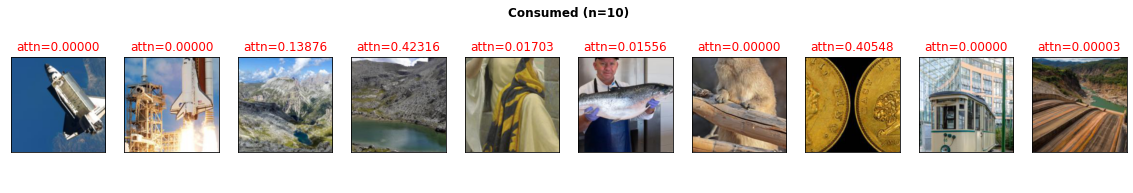

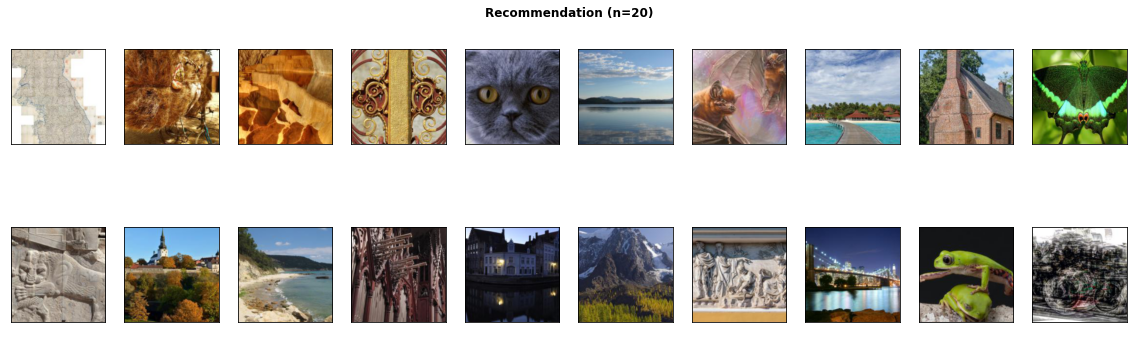

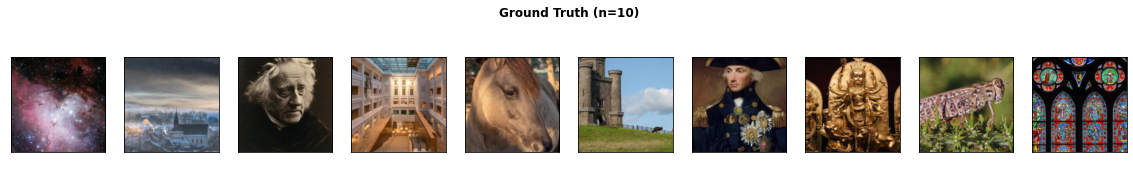

In [15]:
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


COLUMNS = 10
ELEMENTS = {
    "Consumed": profile,
    "Recommendation": ranking,
    "Ground truth": predict,
}
SHOW_FILENAME = False

for label, items in ELEMENTS.items():
    n_rows = ((len(items) - 1) // COLUMNS + 1)
    fig = plt.figure(figsize=(COLUMNS * 2, 3 * n_rows))
    plt.title(f"{label.title()} (n={len(items)})", fontdict={'fontweight': 'bold'})
    plt.axis("off")
    for i, img_id in enumerate(items, start=1):
        img_fn = item_index2fn[img_id]
        image = Image.open(os.path.join(IMAGES_DIR, img_fn))
        image = to_std_size(image)
        ax = fig.add_subplot(n_rows, COLUMNS, i)
        if SHOW_FILENAME:
            ax.set_title(img_fn)
        if label == "Consumed":
            attention_score = profile_attn_dict[img_id] if isinstance(profile_attn_dict[img_id], float) else profile_attn_dict[img_id][0] # TODO: MHAttn
            ax.set_title(f"attn={attention_score:.5f}", color="red")
        elif label == "Recommendation":
            if img_id in predict:
                ax.patch.set_edgecolor("green")
                ax.patch.set_linewidth("5")
                if SHOW_FILENAME:
                    ax.set_title(img_fn, color="green")
                else:
                    ax.set_title("Ground truth", color="green")
            elif img_id in profile:
                ax.patch.set_edgecolor("red")
                ax.patch.set_linewidth("5")
                if SHOW_FILENAME:
                    ax.set_title(img_fn, color="red")
                else:
                    ax.set_title("Consumed", color="red")
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)


## Component Attention

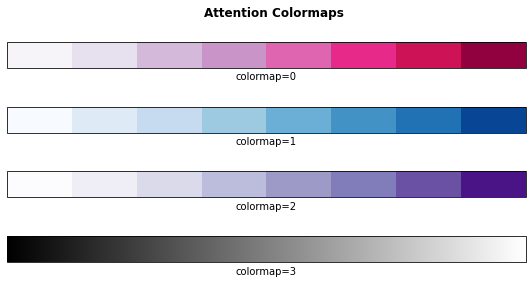

In [16]:
def transparent_cmap(cmap):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = 0.5
    return mycmap


pink_cmap = ListedColormap(['#f7f4f9','#e7e1ef','#d4b9da','#c994c7','#df65b0','#e7298a','#ce1256','#91003f'])
blue_cmap = ListedColormap(['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594'])
purple_cmap = ListedColormap(['#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#4a1486'])

cmaps = [pink_cmap, blue_cmap, purple_cmap, plt.cm.gist_gray]
cmaps = [transparent_cmap(cmap) for cmap in cmaps]

n_rows = len(cmaps)
fig = plt.figure(figsize=(8, 1.2 * n_rows))
plt.title("Attention Colormaps", fontdict={'fontweight': 'bold'})
plt.axis("off")
for i, cmap in enumerate(cmaps):
    ax = fig.add_axes([0.05, 0.75 - (0.75 / n_rows) * i, 0.9, 0.3/n_rows])
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation='horizontal')
    cb.set_label(f'colormap={i}')
    cb.set_ticks([])

plt.show()

In [17]:
profile_idx = 0
cmap_idx = 0

img_id = profile[profile_idx]
img_fn = item_index2fn[img_id]
image = Image.open(os.path.join(IMAGES_DIR, img_fn))
image = to_std_size(image)

image_attn = component_attentions[profile_idx]
image_attn = image_attn.reshape((7,7)).detach().cpu().numpy()
image_attn = Image.fromarray(image_attn)
image_attn = image_attn.resize((224,224))
image_attn = np.array(image_attn)

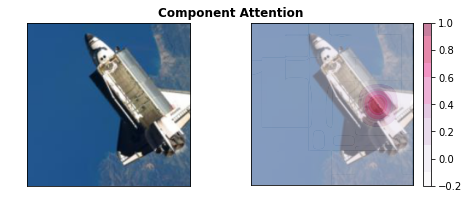

In [18]:
n_columns, n_rows = 2, 1
fig = plt.figure(figsize=(n_columns * 4, 3 * n_rows))

plt.title(f"Component Attention", fontdict={'fontweight': 'bold'})
plt.axis("off")

img_ax = fig.add_subplot(n_rows, n_columns, 1)

plt.xticks([])
plt.yticks([])
img_ax.imshow(image)
    
attn_ax = fig.add_subplot(n_rows, n_columns, 2)

y, x = np.mgrid[0:224, 0:224]
cmap = cmaps[cmap_idx]
cb = attn_ax.contourf(x, y, image_attn, 10, cmap=cmap, antialiased=True)
plt.colorbar(cb)

plt.xticks([])
plt.yticks([])
attn_ax.imshow(image)

plt.show()